In [126]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

In [127]:
# Get the path of the current working directory
current_working_dir = os.path.abspath('')
imgs_path = os.path.join(current_working_dir, 'img')

# Make output directory
output_path = os.path.join(current_working_dir, 'output')
os.makedirs(output_path, exist_ok=True)

In [128]:
# Load the image
img = cv2.imread(os.path.join(imgs_path, '3.jpg'))

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [129]:
# Apply GaussianBlur to the image
blurred = cv2.GaussianBlur(gray, (3, 3), 0)

In [130]:
# Use Sobel operator to get the gradients
grad_x = cv2.Sobel(blurred, cv2.CV_16S, 1, 0, ksize=3)
grad_y = cv2.Sobel(blurred, cv2.CV_16S, 0, 1, ksize=3)
grad_x = cv2.convertScaleAbs(grad_x)
grad_y = cv2.convertScaleAbs(grad_y)

# Calculate the magnitude of the gradients and the angle
magnitude = np.sqrt(grad_x**2 + grad_y**2)
angle = np.arctan2(grad_y, grad_x)

In [131]:
# Not maximum suppression
rows, cols = magnitude.shape
suppressed_normal = np.zeros((rows, cols), dtype=np.uint8)
suppressed_interpolated = np.zeros((rows, cols), dtype=np.uint8)

# Not interploated
for i in range(1, rows-1):
    for j in range(1, cols-1):
        if angle[i, j] < 0:
            angle[i, j] += np.pi
        angle[i, j] = np.rad2deg(angle[i, j])
        if (0 <= angle[i, j] < 22.5) or (157.5 <= angle[i, j] <= 180):
            if magnitude[i, j] > magnitude[i, j-1] and magnitude[i, j] > magnitude[i, j+1]:
                suppressed_normal[i, j] = magnitude[i, j]
        elif 22.5 <= angle[i, j] < 67.5:
            if magnitude[i, j] > magnitude[i-1, j+1] and magnitude[i, j] > magnitude[i+1, j-1]:
                suppressed_normal[i, j] = magnitude[i, j]
        elif 67.5 <= angle[i, j] < 112.5:
            if magnitude[i, j] > magnitude[i-1, j] and magnitude[i, j] > magnitude[i+1, j]:
                suppressed_normal[i, j] = magnitude[i, j]
        elif 112.5 <= angle[i, j] < 157.5:
            if magnitude[i, j] > magnitude[i-1, j-1] and magnitude[i, j] > magnitude[i+1, j+1]:
                suppressed_normal[i, j] = magnitude[i, j]

def interpolate(M1, M2, w):
    if (M1 > M2):
        return (1 + w) * M1 - w * M2
    else:
        return w * M1 + (1 - w) * M2


# Interpolated
for i in range(1, rows - 1):
    for j in range(1, cols - 1):
        # Preprocess the angle
        if angle[i, j] < 0:
            angle[i, j] += np.pi
        angle[i, j] = angle[i, j] % np.pi
        angle[i, j] = np.rad2deg(angle[i, j])

        # Check the angle
        if angle[i, j] == 0:
            if magnitude[i, j] > magnitude[i, j - 1] and magnitude[i, j] > magnitude[i, j + 1]:
                suppressed_interpolated[i, j] = magnitude[i, j]
        elif angle[i, j] == 135:
            if magnitude[i, j] > magnitude[i - 1, j + 1] and magnitude[i, j] > magnitude[i + 1, j - 1]:
                suppressed_interpolated[i, j] = magnitude[i, j]
        elif angle[i, j] == 90:
            if magnitude[i, j] > magnitude[i - 1, j] and magnitude[i, j] > magnitude[i + 1, j]:
                suppressed_interpolated[i, j] = magnitude[i, j]
        elif angle[i, j] == 45:
            if magnitude[i, j] > magnitude[i - 1, j - 1] and magnitude[i, j] > magnitude[i + 1, j + 1]:
                suppressed_interpolated[i, j] = magnitude[i, j]
        elif 0 < angle[i, j] < 45:
            w = 1 / np.tan(angle[i, j])
            dtmp1_mag = interpolate(magnitude[i, j - 1], magnitude[i - 1, j - 1], w)
            dtme2_mag = interpolate(magnitude[i, j + 1], magnitude[i + 1, j + 1], w)
            if magnitude[i, j] > dtmp1_mag and magnitude[i, j] > dtme2_mag:
                suppressed_interpolated[i, j] = magnitude[i, j]
        elif 45 < angle[i, j] < 90:
            w = np.tan(angle[i, j])
            dtmp1_mag = interpolate(magnitude[i - 1, j], magnitude[i - 1, j - 1], w)
            dtme2_mag = interpolate(magnitude[i + 1, j], magnitude[i + 1, j + 1], w)
            if magnitude[i, j] > dtmp1_mag and magnitude[i, j] > dtme2_mag:
                suppressed_interpolated[i, j] = magnitude[i, j]
        elif 90 < angle[i, j] < 135:
            w = np.tan(angle[i, j])
            dtmp1_mag = interpolate(magnitude[i - 1, j], magnitude[i - 1, j + 1], w)
            dtme2_mag = interpolate(magnitude[i + 1, j], magnitude[i + 1, j - 1], w)
            if magnitude[i, j] > dtmp1_mag and magnitude[i, j] > dtme2_mag:
                suppressed_interpolated[i, j] = magnitude[i, j]
        elif 135 < angle[i, j] < 180:
            w = 1 / np.tan(angle[i, j])
            dtmp1_mag = interpolate(magnitude[i, j - 1], magnitude[i - 1, j + 1], w)
            dtme2_mag = interpolate(magnitude[i, j + 1], magnitude[i + 1, j - 1], w)
            if magnitude[i, j] > dtmp1_mag and magnitude[i, j] > dtme2_mag:
                suppressed_interpolated[i, j] = magnitude[i, j]

In [132]:
# Double threshold and edge tracking
def double_threshold(img, low_threshold, high_threshold):
    # 双阈值检测
    strong = 255
    weak = 75

    strong_i, strong_j = np.where(img >= high_threshold)
    weak_i, weak_j = np.where((img >= low_threshold) & (img < high_threshold))
    zeros_i, zeros_j = np.where(img < low_threshold)

    img[strong_i, strong_j] = strong
    img[weak_i, weak_j] = weak
    img[zeros_i, zeros_j] = 0

    return img, weak, strong

def edge_tracking(img, weak, strong=255):
    # 边缘连接
    M, N = img.shape
    for i in range(1, M - 1):
        for j in range(1, N - 1):
            if img[i, j] == weak:
                if strong in [img[i + a, j + b] for a in [-1, 0, 1] for b in [-1, 0, 1]]:
                    img[i, j] = strong
                else:
                    img[i, j] = 0
    return img


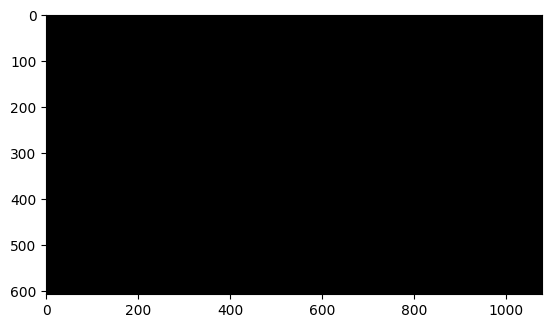

In [133]:
# Test
ratio = 0.4
threshold_high = 100
threshold_low = threshold_high * ratio
edge, weak, strong = double_threshold(suppressed_interpolated, threshold_low, threshold_high)
edge = edge_tracking(edge, weak, strong)

plt.imshow(edge, cmap='gray')
plt.show()